In [30]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt
# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, accuracy_score  # Metricas
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Optimizacion de hiperparametros
import optuna
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fcarreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
bbdd = "sqlite:///op-class2.sqlite3"

In [3]:
df = pd.read_excel('df_op.xlsx')
df["Descripcion"] = df["Descripcion"].fillna("")
df.head(2)

,Tipo comp.,NÂ° Comp.,index,NÂ° cuenta,Desc. Cuenta,NÂ° TesorerÃ­a,Desc. TesorerÃ­a,NÂ° Entidad,Desc. Entidad,Tipo Pres.,...,Monto,Tipo cta,Cod. Bco.,Cta. Cte,NÂ° cta. Safyc,CuentaSafyc,Cuit Pago,Beneficiario Pago,Class,dias_pago
0,AF,163,11643,360000003873122,SGP-RENTAS GRALES-PAGADORA ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,...,1.618424e+08,R,7,1,387312,71387312,30710502354,FDO FID COM CEVIL REDONDO,ANR,34
1,AF,164,75911,71111333,SGP - CTA PAGADORA- CHEQUES DIFERIDOS ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,...,1.444338e+05,P,7,1,111333,71111333,30710500432,FDO FID COM LOS RALOS,PTE,224


In [4]:
# onehot encoding
categ = ['Tipo comp.','Tipo Reg.','Clase Reg.','Tipo cta']
for col in categ:
    df = df.join(pd.get_dummies(df[[col]]))
    df.drop(col, axis=1, inplace=True)



In [5]:
Class = list(df.Class.unique())
clases = {val:Class.index(val) for val in Class}
def get_class(val):
    return clases[val]

df['target'] = df['Class'].apply(get_class)

In [6]:
def limpiar_texto(texto):
    texto = texto.upper()
    texto = re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)(?!PAG)[A-Z0-9]{3,}", texto)
    texto = " ".join(texto).strip()
    return texto

df["texto_limpio"] = df["Descripcion"].apply(limpiar_texto)

In [7]:
wc = WordCloud(' '.join(df['texto_limpio']))
def cloud(data, backgroundcolor = 'black', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

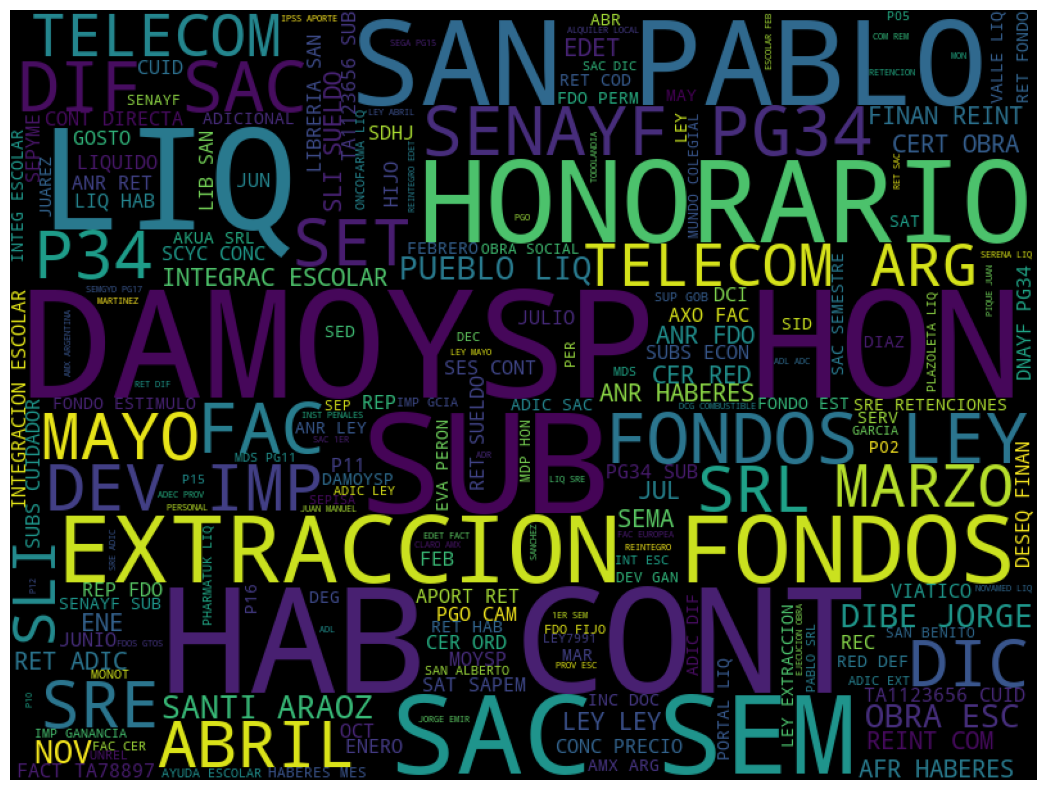

In [8]:
df['tokens'] = df['texto_limpio'].apply(lambda x : str(x or ""))
dfwc = df[df['tokens'] != 'nan']
cloud(' '.join(dfwc['tokens']))


In [32]:

def pesos(texto, dic_words):
    texto = texto.lower()
    palabras = texto.split(' ')
    score = 0
    for palabra in palabras:
        if palabra in dic_words.keys():
            score += dic_words[palabra]
            #print(palabra)
    return score
dictOfWords = {}
for target in df.target.unique():
    df_target = df[df["target"]==target]
    all_descriptions = ' '.join(df_target['texto_limpio'].dropna())  # Concatenar todas las descripciones

    # Tokenización y eliminación de stopwords
    stop_words = set(stopwords.words('spanish')) 
    word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
    filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfa
    freq_of_words = pd.Series(filtered_words).value_counts()
    
    
    dic_words = freq_of_words.to_dict()
    dictOfWords[str(target)] = dic_words
    df[f'pesos_{target}'] = df['texto_limpio'].apply(pesos,dic_words=dic_words)

with open('dict_words.json', 'w') as file:
    json.dump(dictOfWords, file, indent=4)

In [21]:
features = []
for x in enumerate(df.dtypes):
    if x[1] in ["float64","int64","bool"]:
        features.append(df.columns[x[0]])

remove = [ 'Cuit Pago','dias_pago','target','index', 'Cta. Cte','NÂ° cta. Safyc','CuentaSafyc','NÂ° Comp.', 
          'NÂ° TesorerÃ\xada', 'NÂ° Pago','F. Anulado','F. Revertido', 'Cuit alt.','Id. Pe. Ch.','Monto', 'NÂ° Orig.',]

for col in remove:
    try:
        features.remove(col)
    except: pass
features

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R',
 'pesos_0',
 'pesos_1',
 'pesos_2',
 'pesos_3',
 'pesos_4',
 'pesos_5',
 'pesos_6',
 'pesos_7',
 'pesos_8',
 'pesos_9',
 'pesos_10',
 'pesos_11',
 'pesos_12',
 'pesos_13',
 'pesos_14',
 'pesos_15',
 'pesos_16',
 'pesos_17',
 'pesos_18',
 'pesos_19',
 'pesos_20',
 'pesos_21',
 'pesos_22',
 'pesos_23',
 'pesos_24',
 'pesos_25',
 'pesos_26']

In [22]:
X = df[features]


In [24]:
SEED = 12345
TEST_SIZE = 0.2


for col in X.columns:
    if X[col].dtype == 'object':
       X[col] = pd.to_numeric(X[col], errors='coerce')
y = df.target

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [25]:
X.isna().sum()

NÂ° cuenta        0
NÂ° Entidad       0
Cod.              0
Fte. Fin.         0
Cuit              0
Cod. Bco.         0
Tipo comp._AF     0
Tipo comp._FF     0
Tipo comp._GA     0
Tipo comp._GC     0
Tipo comp._GE     0
Tipo Reg._AMP     0
Tipo Reg._ANT     0
Tipo Reg._APE     0
Tipo Reg._CYO     0
Tipo Reg._ORD     0
Tipo Reg._PAG     0
Tipo Reg._RPO     0
Clase Reg._       0
Clase Reg._DPU    0
Clase Reg._OGA    0
Clase Reg._REM    0
Tipo cta_P        0
Tipo cta_R        0
pesos_0           0
pesos_1           0
pesos_2           0
pesos_3           0
pesos_4           0
pesos_5           0
pesos_6           0
pesos_7           0
pesos_8           0
pesos_9           0
pesos_10          0
pesos_11          0
pesos_12          0
pesos_13          0
pesos_14          0
pesos_15          0
pesos_16          0
pesos_17          0
pesos_18          0
pesos_19          0
pesos_20          0
pesos_21          0
pesos_22          0
pesos_23          0
pesos_24          0
pesos_25          0


## KAPPA SCORE

In [26]:
kappa_scorer = make_scorer(cohen_kappa_score)
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Número de clases
        'metric': 'multi_logloss',  # Esto es solo para LightGBM; la métrica de optimización será accuracy
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'verbose': -1,
    }
    
    # Crear el dataset de LightGBM
    model = lgb.LGBMClassifier(**param,verbose_eval=False)
    
    # Realizar validación cruzada usando Kappa como métrica
    kappa = cross_val_score(model, X_train, y_train, cv=3, scoring=kappa_scorer).mean()
    
    return kappa


# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize', 
                            storage=bbdd,  # Specify the storage URL here.
                            study_name="lgbm kappa sin monto textmining custom",
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(set(y))
best_model = lgb.LGBMClassifier(**best_params,verbose_eval=False)

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
test_kappa = cohen_kappa_score(y_test, y_pred)

print(f'Kappa en el conjunto de prueba: {test_kappa:.4f}')

[I 2024-08-13 14:29:58,451] A new study created in RDB with name: lgbm kappa sin monto textmining custom
[I 2024-08-13 14:30:06,810] Trial 0 finished with value: 0.6139082607763767 and parameters: {'learning_rate': 0.0018536051117055378, 'num_leaves': 57, 'max_depth': 4, 'min_child_samples': 51, 'subsample': 0.9925168408439108, 'colsample_bytree': 0.7995586207875438, 'reg_alpha': 1.145001909795221e-07, 'reg_lambda': 0.08999161961036403}. Best is trial 0 with value: 0.6139082607763767.
[I 2024-08-13 14:30:15,981] Trial 1 finished with value: 0.9587886531733165 and parameters: {'learning_rate': 0.00446489982261589, 'num_leaves': 213, 'max_depth': -1, 'min_child_samples': 52, 'subsample': 0.7694620889350825, 'colsample_bytree': 0.9856286894816986, 'reg_alpha': 1.2830718555863821e-05, 'reg_lambda': 0.8014603381285093}. Best is trial 1 with value: 0.9587886531733165.
[I 2024-08-13 14:30:25,805] Trial 2 finished with value: 0.5149163047838673 and parameters: {'learning_rate': 0.0012921002977

Mejores hiperparámetros: {'learning_rate': 0.08068584180048805, 'num_leaves': 243, 'max_depth': 11, 'min_child_samples': 91, 'subsample': 0.5789251781933781, 'colsample_bytree': 0.7179992412555387, 'reg_alpha': 0.01688492119576998, 'reg_lambda': 0.9776961430551896}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 49
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training 

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba:", accuracy)

Exactitud en el conjunto de prueba: 0.9915893896916109


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4811
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 49
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training from score -6.994823
[LightGBM] [Info] Start training from score -6.010324
[LightGBM] [Info] Start training from score -6.190450
[LightGBM] [Info] Start training from score -5.876793
[LightGBM] [Info] Start training from score -1.368896
[LightGBM] [Info] Start training from score -3.893142
[LightGBM] [Info] Start training from score -3.089292
[LightGBM] [Info] Start tra

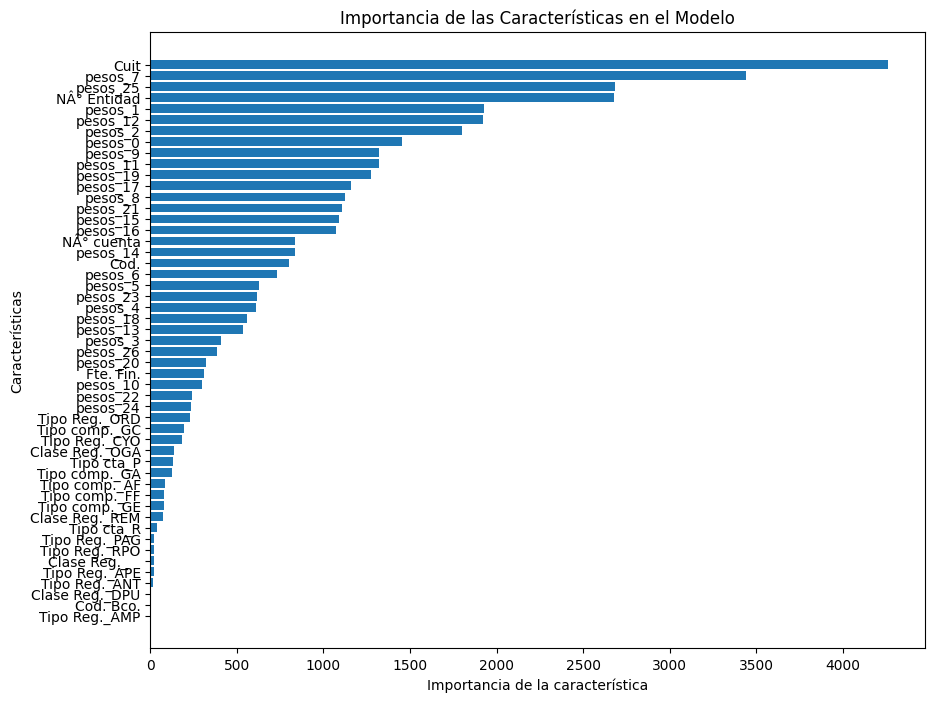

In [28]:
import matplotlib.pyplot as plt

# Asumiendo que ya has entrenado tu modelo con los mejores hiperparámetros encontrados
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Obtener la importancia de las características
importance = best_model.feature_importances_

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Mostrar el DataFrame con la importancia de las variables
print(importance_df)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo')
plt.gca().invert_yaxis()
plt.show()


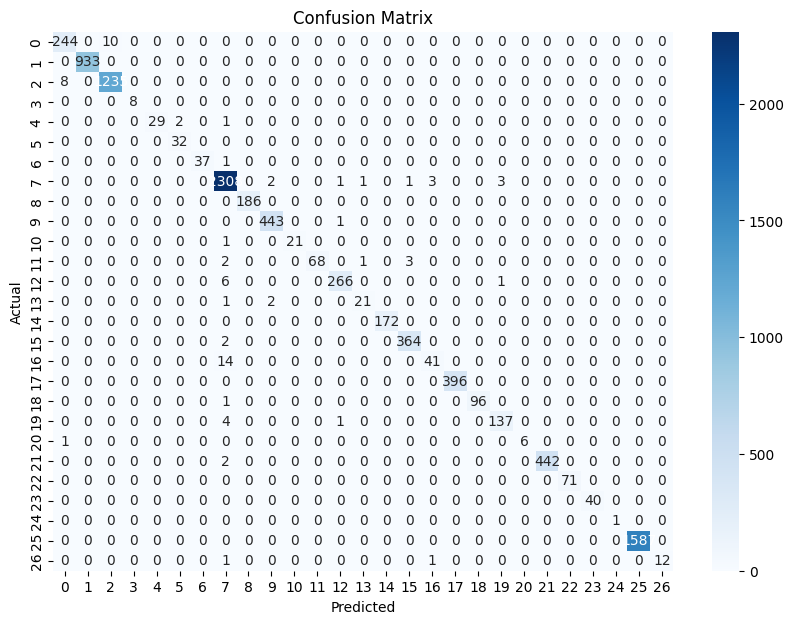

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
